### Libs

In [257]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Functions

In [258]:
def show_scatter(dataset, title, tf, x, y):

    # Set the size of the plot
    plt.figure(figsize=(10, 6))  # Width and height in inches

    # Add regression line
    # sns.regplot(x='Price_steth', y='Price_cme', data=dataset, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
    sns.regplot(x=x, y=y, data=dataset, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})

    # Plotting the dataset
    sns.scatterplot(x=x, y=y, data=dataset)
    plt.title(f'Scatter Plot of {title} Price on {tf} timeframe')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

In [259]:
def remove_outliers(df, x, y):
    for col in [x, y]:
        q_low = df[col].quantile(0.01)
        q_high = df[col].quantile(0.99)
        df = df[(df[col] > q_low) & (df[col] < q_high)]
    return df


### Data loads

In [276]:
col_names = ['Entry Date UTC', 'Price']

# Load CME ETH data from Trading View (1h)
cme_data_1h_tv = pd.read_csv('../data/cme/cme_1h_tv.csv', usecols=col_names)
cme_data_1h_tv['Entry Date UTC'] = pd.to_datetime(cme_data_1h_tv['Entry Date UTC'], utc=True)

# Load stETH data from Trading View (1h)
steth_data_1h_tv = pd.read_csv('../data/steth/steth_1h_tv.csv', usecols=col_names)
steth_data_1h_tv['Entry Date UTC'] = pd.to_datetime(steth_data_1h_tv['Entry Date UTC'], utc=True)

# Load CME ETH data from CME Group (1m, 5m, 1h)
cme_data_1m_cme = pd.read_csv('../data/cme/cme_1m_cme.csv', usecols=col_names)
cme_data_1m_cme['Entry Date UTC'] = pd.to_datetime(
        cme_data_1m_cme['Entry Date UTC'],
        format='%Y%m%dT%H:%M:%S',
        utc=True
    )
cme_data_1m_cme.set_index('Entry Date UTC', inplace=True)
cme_data_1h_cme = cme_data_1m_cme[cme_data_1m_cme.index.minute == 0]
cme_data_5m_cme = cme_data_1m_cme[cme_data_1m_cme.index.minute % 5 == 0]
cme_data_1h_cme.reset_index(inplace=True)
cme_data_5m_cme.reset_index(inplace=True)

# Load ETH data from Trading View (1h)
eth_data_1h_tv = pd.read_csv('../data/eth/eth_1h_tv.csv', usecols=col_names)
eth_data_1h_tv['Entry Date UTC'] = pd.to_datetime(eth_data_1h_tv['Entry Date UTC'], utc=True)

# Load ETH data from Dune prices.usd(5m, 1h)
eth_data_5m_dune = pd.read_csv('../data/eth/eth_5m_dune.csv', usecols=col_names)
eth_data_5m_dune['Entry Date UTC'] = pd.to_datetime(eth_data_5m_dune['Entry Date UTC'], utc=True)
eth_data_5m_dune.set_index('Entry Date UTC', inplace=True)
eth_data_1h_dune = eth_data_5m_dune[eth_data_5m_dune.index.minute == 0]
eth_data_1h_dune.reset_index(inplace=True)

# Load stETH data from Dune dex.trades [1m, 5m, 1h]
steth_data_1h_dune = pd.read_csv('../data/steth/steth_1h.csv', usecols=col_names)
steth_data_1h_dune['Entry Date UTC'] = pd.to_datetime(
    steth_data_1h_dune['Entry Date UTC'],
    format='%Y-%m-%dT%H:%M:%S',
    utc=True
)

# Load stETH only data from Dune prices.usd (1m)
steth_data_1m_dune_stethonly = pd.read_csv('../data/steth/steth_only_1m.csv', usecols=col_names)
steth_data_1m_dune_stethonly['Entry Date UTC'] = pd.to_datetime(
    steth_data_1m_dune_stethonly['Entry Date UTC'],
    utc=True
)
steth_data_1m_dune_stethonly.set_index('Entry Date UTC', inplace=True)
steth_data_1h_dune_stethonly = steth_data_1m_dune_stethonly[steth_data_1m_dune_stethonly.index.minute == 0]
steth_data_1h_dune_stethonly.reset_index(inplace=True)

# Load ETH from Dune dex.trades on Uniswap only from ethereum using price average(1m)
eth_data_1m_dune_dex = pd.read_csv('../data/steth/weth_1m.csv', usecols=col_names)
eth_data_1m_dune_dex['Entry Date UTC'] = pd.to_datetime(
    eth_data_1m_dune_dex['Entry Date UTC'],
    utc=True
)
eth_data_1m_dune_dex.set_index('Entry Date UTC', inplace=True)
eth_data_1h_dune_dex = eth_data_1m_dune_dex[eth_data_1m_dune_dex.index.minute == 0]
eth_data_1h_dune_dex.reset_index(inplace=True)

# Load ETH from Dune dex.trades on Uniswap only from ethereum using vwap (1m)
eth_data_1m_dune_dex_vwap = pd.read_csv('../data/eth/eth_vwap_1m.csv', usecols=col_names)
eth_data_1m_dune_dex_vwap['Entry Date UTC'] = pd.to_datetime(
    eth_data_1m_dune_dex_vwap['Entry Date UTC'],
    utc=True
)
eth_data_1m_dune_dex_vwap.set_index('Entry Date UTC', inplace=True)
eth_data_1h_dune_dex_vwap = eth_data_1m_dune_dex[eth_data_1m_dune_dex_vwap.index.minute == 0]
eth_data_1h_dune_dex_vwap.reset_index(inplace=True)

### Merge CME ETH [Trading View] & ETH [Trading View]

In [261]:
# Merge datasets
dataset_1h_tv = pd.merge(cme_data_1h_tv, eth_data_1h_tv, on='Entry Date UTC', suffixes=('_cme', '_eth'))

# Calculate diff & return on prices
dataset_1h_tv['Price_cme_delta'] = dataset_1h_tv['Price_cme'].diff()
dataset_1h_tv['Price_eth_delta'] = dataset_1h_tv['Price_eth'].diff()
dataset_1h_tv['Price_cme_return'] = dataset_1h_tv['Price_cme'].pct_change()
dataset_1h_tv['Price_eth_return'] = dataset_1h_tv['Price_eth'].pct_change()

# Remove null values
dataset_1h_tv.dropna(subset=['Price_cme_return', 'Price_eth_return'], inplace=True)

### Merge CME ETH [CME Group] & ETH [Trading View]

In [262]:
# Merge datasets
dataset_1h_cme_tv = pd.merge(cme_data_1h_cme, eth_data_1h_tv, on='Entry Date UTC', suffixes=('_cme', '_eth'))

# Calculate diff & return on prices
dataset_1h_cme_tv['Price_cme_delta'] = dataset_1h_cme_tv['Price_cme'].diff()
dataset_1h_cme_tv['Price_eth_delta'] = dataset_1h_cme_tv['Price_eth'].diff()
dataset_1h_cme_tv['Price_cme_return'] = dataset_1h_cme_tv['Price_cme'].pct_change()
dataset_1h_cme_tv['Price_eth_return'] = dataset_1h_cme_tv['Price_eth'].pct_change()

# Remove null values
dataset_1h_cme_tv.dropna(subset=['Price_cme_return', 'Price_eth_return'], inplace=True)

# Remove outliers
# dataset_1h_cme_tv = remove_outliers(dataset_1h_cme_tv, 'Price_cme_return', 'Price_eth_return')

### Merge CME ETH [CME Group] & stETH [Trading View]

In [279]:
# Merge datasets
dataset_1h_steth_cme_tv = pd.merge(cme_data_1h_cme, steth_data_1h_tv, on='Entry Date UTC', suffixes=('_cme', '_eth'))

# Calculate diff & return on prices
dataset_1h_steth_cme_tv['Price_cme_delta'] = dataset_1h_steth_cme_tv['Price_cme'].diff()
dataset_1h_steth_cme_tv['Price_eth_delta'] = dataset_1h_steth_cme_tv['Price_eth'].diff()
dataset_1h_steth_cme_tv['Price_cme_return'] = dataset_1h_steth_cme_tv['Price_cme'].pct_change()
dataset_1h_steth_cme_tv['Price_eth_return'] = dataset_1h_steth_cme_tv['Price_eth'].pct_change()

# Remove null values
dataset_1h_steth_cme_tv.dropna(subset=['Price_cme_return', 'Price_eth_return'], inplace=True)

### Merge CME ETH [Trading View] & ETH [Dune's prices.usd]

In [264]:
# Merge datasets
dataset_1h_tv_dune = pd.merge(cme_data_1h_tv, eth_data_1h_dune, on='Entry Date UTC', suffixes=('_cme', '_eth'))

# Calculate diff & return on prices
dataset_1h_tv_dune['Price_cme_delta'] = dataset_1h_tv_dune['Price_cme'].diff()
dataset_1h_tv_dune['Price_eth_delta'] = dataset_1h_tv_dune['Price_eth'].diff()
dataset_1h_tv_dune['Price_cme_return'] = dataset_1h_tv_dune['Price_cme'].pct_change()
dataset_1h_tv_dune['Price_eth_return'] = dataset_1h_tv_dune['Price_eth'].pct_change()

# Remove null values
dataset_1h_tv_dune.dropna(subset=['Price_cme_return', 'Price_eth_return'], inplace=True)

### Merge CME ETH [Trading View] & stETH+wsSETH [Dune's dex.trades]

In [265]:
# Merge datasets
dataset_1h_tv_dunest = pd.merge(cme_data_1h_tv, steth_data_1h_dune, on='Entry Date UTC', suffixes=('_cme', '_eth'))

# Calculate diff & return on prices
dataset_1h_tv_dunest['Price_cme_delta'] = dataset_1h_tv_dunest['Price_cme'].diff()
dataset_1h_tv_dunest['Price_eth_delta'] = dataset_1h_tv_dunest['Price_eth'].diff()
dataset_1h_tv_dunest['Price_cme_return'] = dataset_1h_tv_dunest['Price_cme'].pct_change()
dataset_1h_tv_dunest['Price_eth_return'] = dataset_1h_tv_dunest['Price_eth'].pct_change()

# Remove outliers
dataset_1h_tv_dunest = remove_outliers(dataset_1h_tv_dunest, 'Price_cme_return', 'Price_eth_return')

# Remove null values
dataset_1h_tv_dunest.dropna(subset=['Price_cme_return', 'Price_eth_return'], inplace=True)

### Merge CME ETH [Trading View] & stETH only [Dune's dex.trades]

In [266]:
# Merge datasets
dataset_1h_tv_dune_steth_only = pd.merge(cme_data_1h_tv, steth_data_1h_dune_stethonly, on='Entry Date UTC', suffixes=('_cme', '_eth'))

# Calculate diff & return on prices
dataset_1h_tv_dune_steth_only['Price_cme_delta'] = dataset_1h_tv_dune_steth_only['Price_cme'].diff()
dataset_1h_tv_dune_steth_only['Price_eth_delta'] = dataset_1h_tv_dune_steth_only['Price_eth'].diff()
dataset_1h_tv_dune_steth_only['Price_cme_return'] = dataset_1h_tv_dune_steth_only['Price_cme'].pct_change()
dataset_1h_tv_dune_steth_only['Price_eth_return'] = dataset_1h_tv_dune_steth_only['Price_eth'].pct_change()

# Remove outliers
dataset_1h_tv_dune_steth_only = remove_outliers(dataset_1h_tv_dune_steth_only, 'Price_cme_return', 'Price_eth_return')

# Remove null values
dataset_1h_tv_dune_steth_only.dropna(subset=['Price_cme_return', 'Price_eth_return'], inplace=True)

### Merge CME ETH [CME Group] vs. ETH [Dune dex.trades for Uniswap in Ethereum using average price per minute]

In [267]:

# Merge datasets
dataset_1h_cme_dunedex = pd.merge(cme_data_1h_cme, eth_data_1h_dune_dex, on='Entry Date UTC', suffixes=('_cme', '_eth'))

# Calculate diff & return on prices
dataset_1h_cme_dunedex['Price_cme_delta'] = dataset_1h_cme_dunedex['Price_cme'].diff()
dataset_1h_cme_dunedex['Price_eth_delta'] = dataset_1h_cme_dunedex['Price_eth'].diff()
dataset_1h_cme_dunedex['Price_cme_return'] = dataset_1h_cme_dunedex['Price_cme'].pct_change()
dataset_1h_cme_dunedex['Price_eth_return'] = dataset_1h_cme_dunedex['Price_eth'].pct_change()

# Remove outliers
# dataset_1h_cme_dunedex = remove_outliers(dataset_1h_cme_dunedex, 'Price_cme_return', 'Price_eth_return')

# Remove null values
dataset_1h_cme_dunedex.dropna(subset=['Price_cme_return', 'Price_eth_return'], inplace=True)


### Merge CME ETH [CME Group] vs. ETH [Dune dex.trades for Uniswap in Ethereum using vwap]

In [268]:
# Merge datasets
dataset_1h_cme_dunedex_vwap = pd.merge(cme_data_1h_cme, eth_data_1h_dune_dex_vwap, on='Entry Date UTC', suffixes=('_cme', '_eth'))

# Calculate diff & return on prices
dataset_1h_cme_dunedex_vwap['Price_cme_delta'] = dataset_1h_cme_dunedex_vwap['Price_cme'].diff()
dataset_1h_cme_dunedex_vwap['Price_eth_delta'] = dataset_1h_cme_dunedex_vwap['Price_eth'].diff()
dataset_1h_cme_dunedex_vwap['Price_cme_return'] = dataset_1h_cme_dunedex_vwap['Price_cme'].pct_change()
dataset_1h_cme_dunedex_vwap['Price_eth_return'] = dataset_1h_cme_dunedex_vwap['Price_eth'].pct_change()

# Remove outliers
# dataset_1h_cme_dunedex = remove_outliers(dataset_1h_cme_dunedex, 'Price_cme_return', 'Price_eth_return')

# Remove null values
dataset_1h_cme_dunedex_vwap.dropna(subset=['Price_cme_return', 'Price_eth_return'], inplace=True)

### Correlations

In [281]:
# Calculate correlations for both datasets
corr_1h_tv = dataset_1h_tv['Price_cme_return'].corr(dataset_1h_tv['Price_eth_return'])
corr_1h_cme_tv = dataset_1h_cme_tv['Price_cme_return'].corr(dataset_1h_cme_tv['Price_eth_return'])
corr_1h_steth_cme_tv = dataset_1h_steth_cme_tv['Price_cme_return'].corr(dataset_1h_steth_cme_tv['Price_eth_return'])
corr_1h_tv_dune = dataset_1h_tv_dune['Price_cme_return'].corr(dataset_1h_tv_dune['Price_eth_return'])
corr_1h_tv_dunest = dataset_1h_tv_dunest['Price_cme_return'].corr(dataset_1h_tv_dunest['Price_eth_return'])
corr_1h_tv_dune_steth_only = dataset_1h_tv_dune_steth_only['Price_cme_return'].corr(dataset_1h_tv_dune_steth_only['Price_eth_return'])
corr_1h_cme_dunedex = dataset_1h_cme_dunedex['Price_cme_return'].corr(dataset_1h_cme_dunedex['Price_eth_return'])
corr_1h_cme_dunedex_vwap = dataset_1h_cme_dunedex_vwap['Price_cme_return'].corr(dataset_1h_cme_dunedex_vwap['Price_eth_return'])

print('cme eth [trading view] vs. eth [trading view]')
print(f"1h corr: {corr_1h_tv}\n")

print('cme eth [cme group] vs. eth [trading view]')
print(f"1h corr: {corr_1h_cme_tv}\n")

print('cme eth [cme group] vs. steth [trading view]')
print(f"1h corr: {corr_1h_steth_cme_tv}\n")

# print('cme eth [cme group] vs. eth [AVG dune dex.trades on uniswap in ethereum]')
# print(f"1h corr: {corr_1h_cme_dunedex}\n")

print('cme eth [cme group] vs. eth [VWAP dune dex.trades on uniswap in ethereum]')
print(f"1h corr: {corr_1h_cme_dunedex_vwap}\n")

print('cme eth [trading view] vs. eth [dune prices.usd]')
print(f"1h corr: {corr_1h_tv_dune}\n")

print('cme eth [trading view] vs. steth+wsteth [dune dex.trades]')
print(f"1h corr: {corr_1h_tv_dunest}\n")

print('cme eth [trading view] vs. steth [dune dex.trades]')
print(f"1h corr: {corr_1h_tv_dune_steth_only}")

cme eth [trading view] vs. eth [trading view]
1h corr: 0.9850574832964637

cme eth [cme group] vs. eth [trading view]
1h corr: 0.9808721585756048

cme eth [cme group] vs. steth [trading view]
1h corr: 0.7120361962577353

cme eth [cme group] vs. eth [VWAP dune dex.trades on uniswap in ethereum]
1h corr: 0.9369166016010368

cme eth [trading view] vs. eth [dune prices.usd]
1h corr: 0.9191664770716793

cme eth [trading view] vs. steth+wsteth [dune dex.trades]
1h corr: 0.7408207731853602

cme eth [trading view] vs. steth [dune dex.trades]
1h corr: 0.9196473913257585


In [270]:
dataset_1h_cme_tv.head()

,Entry Date UTC,Price_cme,Price_eth,Price_cme_delta,Price_eth_delta,Price_cme_return,Price_eth_return
1,2023-01-03 00:00:00+00:00,1211.5,1213.69,-2.5,-1.22,-0.002059,-0.001004
2,2023-01-03 01:00:00+00:00,1212.0,1215.41,0.5,1.72,0.000413,0.001417
3,2023-01-03 02:00:00+00:00,1210.0,1213.73,-2.0,-1.68,-0.001650,-0.001382
4,2023-01-03 03:00:00+00:00,1209.5,1213.80,-0.5,0.07,-0.000413,0.000058
5,2023-01-03 06:00:00+00:00,1214.0,1217.47,4.5,3.67,0.003721,0.003024


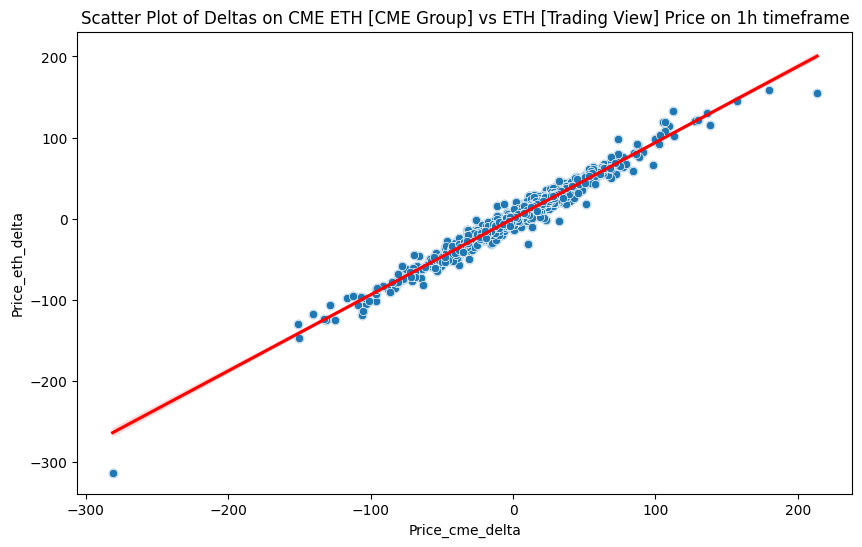

In [271]:
show_scatter(dataset_1h_cme_tv, 'Deltas on CME ETH [CME Group] vs ETH [Trading View]', '1h', 'Price_cme_delta', 'Price_eth_delta')

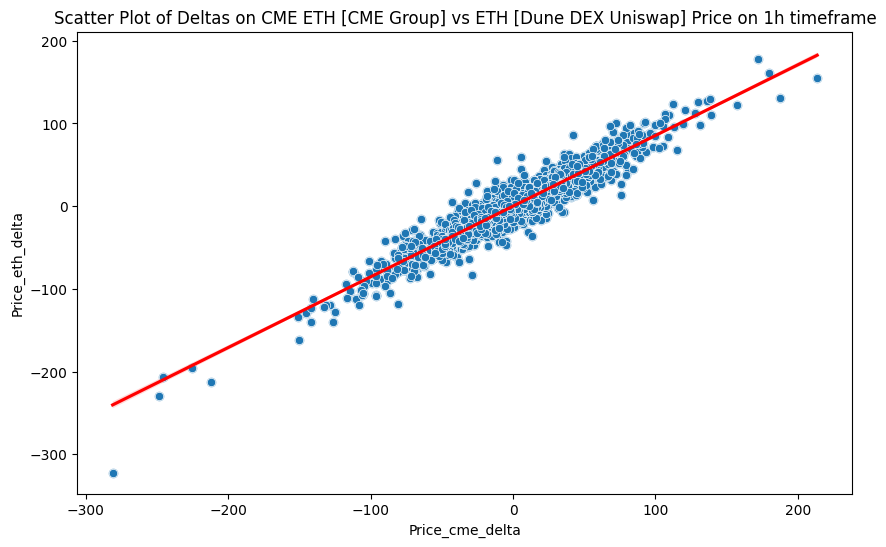

In [272]:
show_scatter(dataset_1h_cme_dunedex, 'Deltas on CME ETH [CME Group] vs ETH [Dune DEX Uniswap]', '1h', 'Price_cme_delta', 'Price_eth_delta')

In [273]:
eth_data_1h_tv.head(10)

,Entry Date UTC,Price
0,2023-01-01 01:00:00+00:00,1193.35
1,2023-01-01 02:00:00+00:00,1195.11
2,2023-01-01 03:00:00+00:00,1194.76
3,2023-01-01 04:00:00+00:00,1193.09
4,2023-01-01 05:00:00+00:00,1192.16
5,2023-01-01 06:00:00+00:00,1193.44
6,2023-01-01 07:00:00+00:00,1193.87
7,2023-01-01 08:00:00+00:00,1194.27
8,2023-01-01 09:00:00+00:00,1193.49
9,2023-01-01 10:00:00+00:00,1195.59


In [274]:
steth_data_1h_tv.head(10)

,Entry Date UTC,Price
0,2023-01-01 00:00:00+00:00,1152.04
1,2023-01-01 01:00:00+00:00,1152.05
2,2023-01-01 02:00:00+00:00,1168.09
3,2023-01-01 03:00:00+00:00,1169.00
4,2023-01-01 04:00:00+00:00,1170.80
5,2023-01-01 05:00:00+00:00,1169.01
6,2023-01-01 06:00:00+00:00,1169.01
7,2023-01-01 07:00:00+00:00,1196.50
8,2023-01-01 08:00:00+00:00,1168.63
9,2023-01-01 09:00:00+00:00,1180.53
